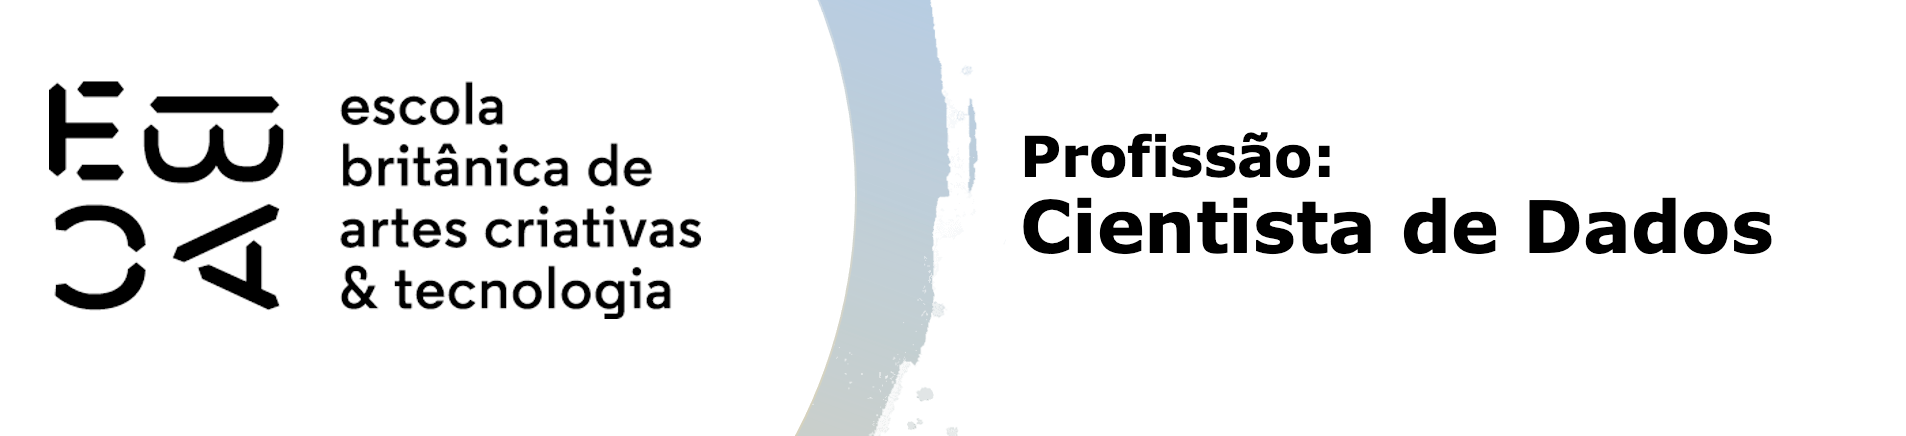

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Carregar os dados
df = pd.read_pickle('base_nfp.pkl')

# Visualizar as primeiras linhas
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
# Convertendo a coluna Data Emissão para datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Criar variáveis temporais
df['Dia da Semana'] = df['Data Emissão'].dt.dayofweek
df['Fim de Semana'] = (df['Dia da Semana'] >= 5).astype(int)
df['Dia do Mês'] = df['Data Emissão'].dt.day
df['Mês'] = df['Data Emissão'].dt.month
df['Trimestre'] = df['Data Emissão'].dt.to_period('Q').astype(str)
df['Ano'] = df['Data Emissão'].dt.year

# Definir quantis
quantis = [0, 0.05, 0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 1]

# Categorizar o valor da nota
df['Valor NF Categoria 5'] = pd.qcut(df['Valor NF'], q=5, labels=False)
df['Valor NF Categoria 10'] = pd.qcut(df['Valor NF'], q=10, labels=False)
df['Valor NF Categoria 20'] = pd.qcut(df['Valor NF'], q=20, labels=False)
df['Valor NF Categoria 50'] = pd.qcut(df['Valor NF'], q=50, labels=False)



## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [4]:
def calculate_iv(df, feature, target):
    # Criar tabelas de frequência
    freq = df.groupby(feature)[target].agg(['count', 'sum'])
    freq['percent'] = freq['count'] / freq['count'].sum()
    freq['good'] = freq['sum']
    freq['bad'] = freq['count'] - freq['good']
    freq['good_dist'] = freq['good'] / freq['good'].sum()
    freq['bad_dist'] = freq['bad'] / freq['bad'].sum()
    freq['woe'] = np.log(freq['good_dist'] / freq['bad_dist']).replace([np.inf, -np.inf], 0)
    freq['iv'] = (freq['good_dist'] - freq['bad_dist']) * freq['woe']
    iv = freq['iv'].sum()
    return iv

# Calcular IV para variáveis categóricas
iv_values = {}
categorical_features = ['Dia da Semana', 'Fim de Semana', 'Dia do Mês', 'Mês', 'Trimestre', 'Ano', 
                         'Valor NF Categoria 5', 'Valor NF Categoria 10', 'Valor NF Categoria 20', 'Valor NF Categoria 50', 
                         'categoria']

for feature in categorical_features:
    iv = calculate_iv(df, feature, 'flag_credito')
    iv_values[feature] = iv

iv_values

{'Dia da Semana': 0.006883336112261752,
 'Fim de Semana': 0.0043461438854261675,
 'Dia do Mês': 0.04371881239108832,
 'Mês': 0.027833010669221996,
 'Trimestre': 0.07988781023295063,
 'Ano': 0.04176125882467792,
 'Valor NF Categoria 5': 0.05669465698593576,
 'Valor NF Categoria 10': 0.10664979368195977,
 'Valor NF Categoria 20': 0.12452461379728179,
 'Valor NF Categoria 50': 0.1523145641483627,
 'categoria': 0.40831279222730105}

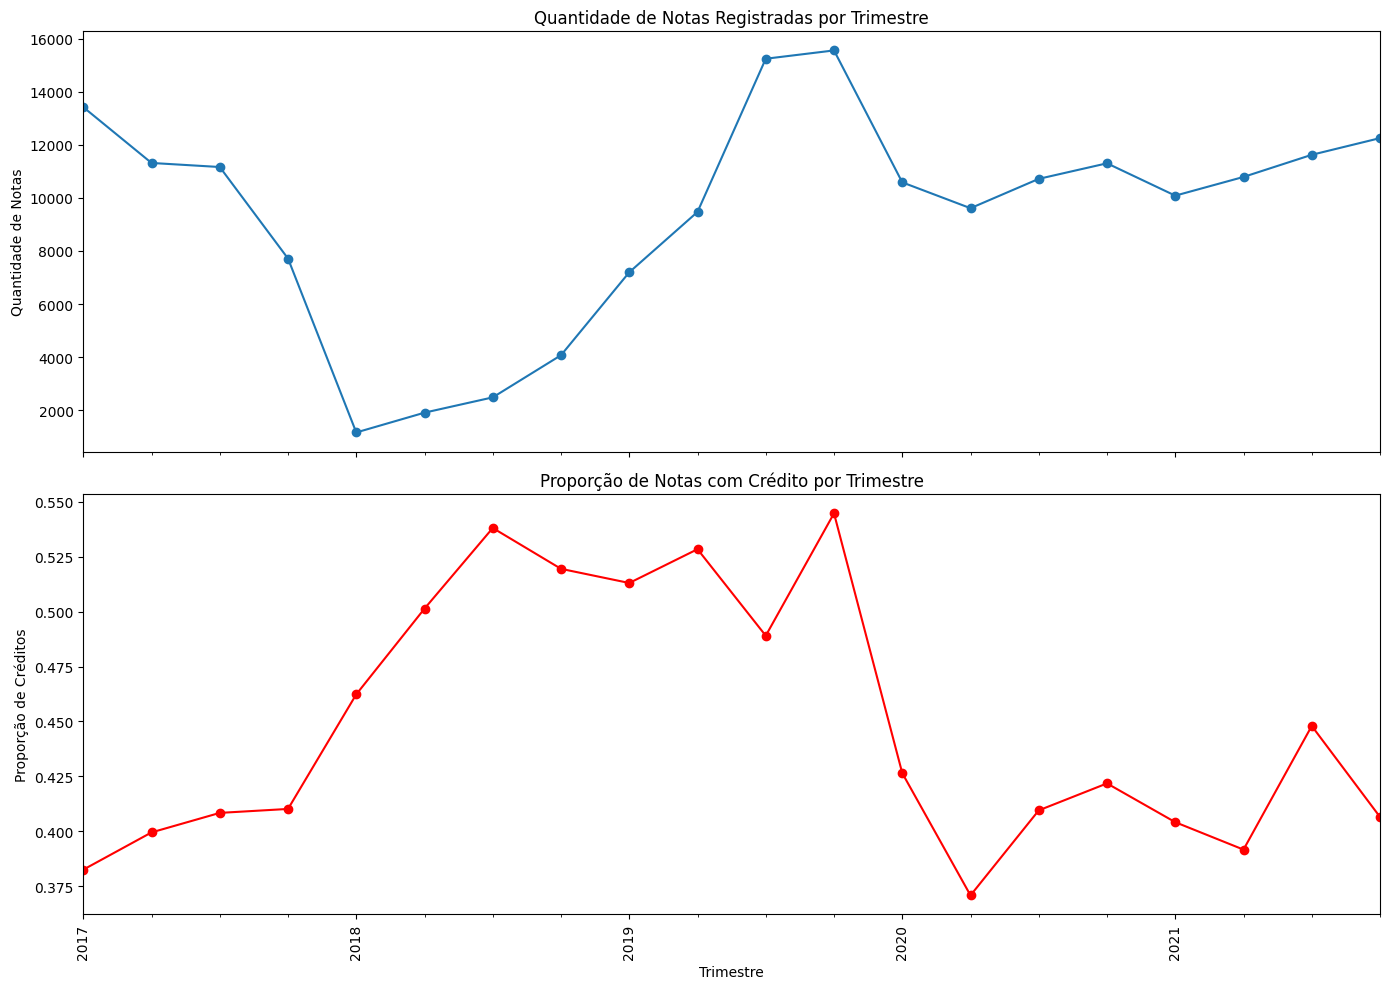

In [5]:
# Agregar dados trimestrais
df['Trimestre'] = df['Data Emissão'].dt.to_period('Q')
df_trimestre = df.groupby(['Trimestre', 'categoria']).agg(
    quantidade_notas=('No.', 'count'),
    quantidade_creditos=('Créditos', 'sum'),
    proporcao_creditos=('flag_credito', 'mean')
).reset_index()

# Plotar a quantidade de notas e proporção de créditos
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Quantidade de notas
df_trimestre.groupby('Trimestre')['quantidade_notas'].sum().plot(ax=ax[0], marker='o')
ax[0].set_title('Quantidade de Notas Registradas por Trimestre')
ax[0].set_ylabel('Quantidade de Notas')

# Proporção de créditos
df_trimestre.groupby('Trimestre')['proporcao_creditos'].mean().plot(ax=ax[1], marker='o', color='r')
ax[1].set_title('Proporção de Notas com Crédito por Trimestre')
ax[1].set_ylabel('Proporção de Créditos')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<span style="color:orange">

- **Variáveis com o maior poder de discriminação** são aquelas com valores de IV mais altos. Neste caso, a variável `categoria` possui o maior IV (0.40831), indicando que ela tem a melhor capacidade de discriminar entre notas fiscais que geram créditos e aquelas que não geram.
- A variável `Valor NF Categoria 50` tem o segundo maior IV (0.15231), seguida por `Valor NF Categoria 20` (0.12452).

## **Relação entre Número de Categorias e IV para Variáveis Contínuas**

**Análise dos IVs das variáveis categorizadas por `Valor NF`:**

- `Valor NF Categoria 5`: 0.05669
- `Valor NF Categoria 10`: 0.10665
- `Valor NF Categoria 20`: 0.12452
- `Valor NF Categoria 50`: 0.15231

**Observações:**

- **Tendência**: O IV aumenta com o número de categorias. Isso sugere que variáveis contínuas com mais categorias tendem a ter maior poder de discriminação. Variáveis categorizadas em mais faixas podem capturar mais nuances nos dados, aumentando o IV.
  
</span>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

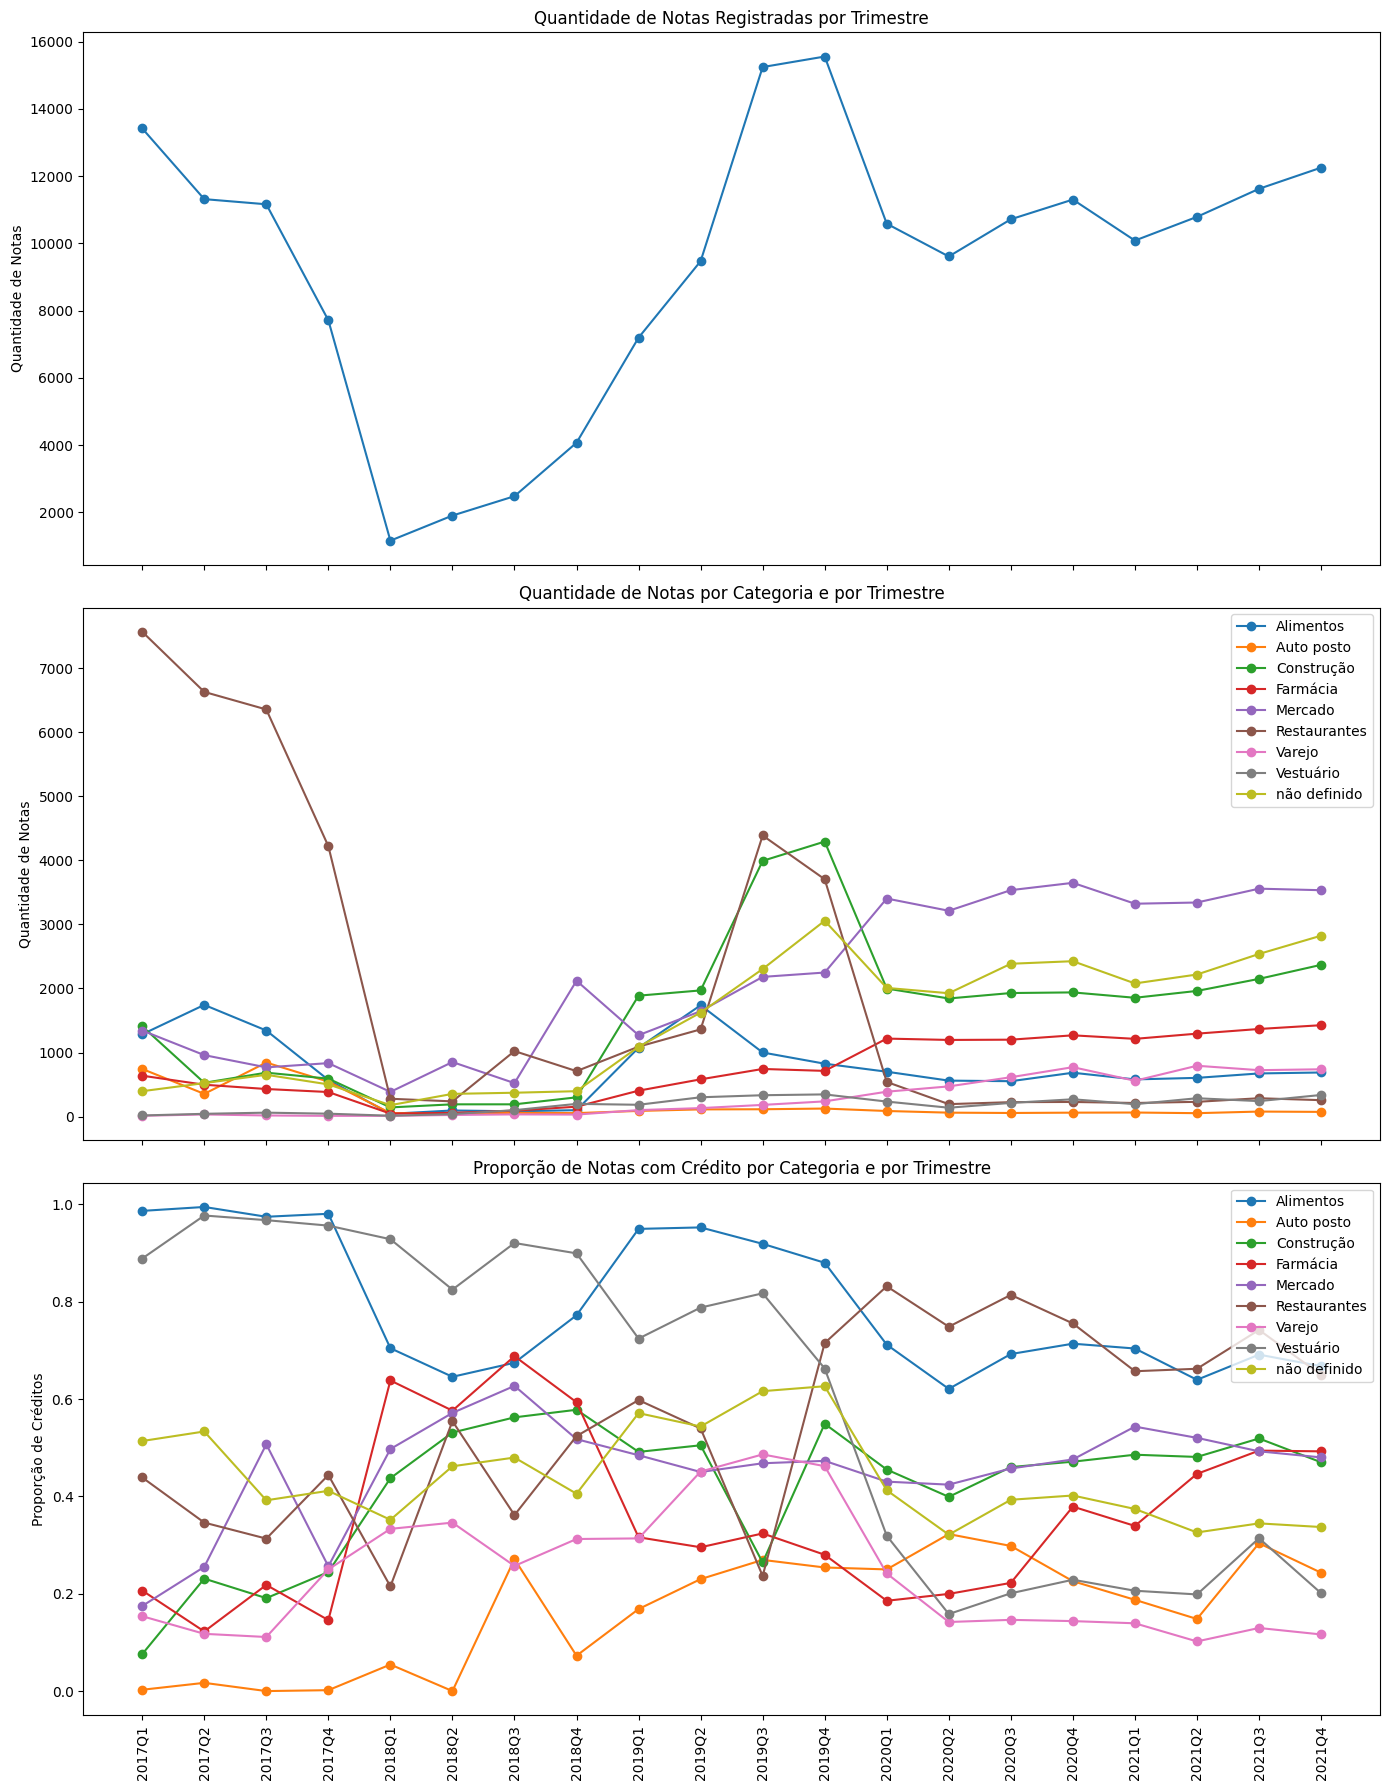

In [10]:
# Converter 'Data Emissão' para datetime e criar a coluna 'Trimestre'
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])
df['Trimestre'] = df['Data Emissão'].dt.to_period('Q')

# Quantidade de notas registradas por período
quantidade_notas = df.groupby('Trimestre').size()

# Quantidade de notas por categoria e por período
quantidade_notas_categoria = df.groupby(['Trimestre', 'categoria']).size().unstack().fillna(0)

# Proporção de notas com crédito por categoria e por período
proporcao_creditos_categoria = df.groupby(['Trimestre', 'categoria']).agg(
    total_notas=('No.', 'size'),
    total_creditos=('flag_credito', 'sum')
).reset_index()
proporcao_creditos_categoria['proporcao_creditos'] = proporcao_creditos_categoria['total_creditos'] / proporcao_creditos_categoria['total_notas']

# Plotar
fig, ax = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Quantidade de notas
ax[0].plot(quantidade_notas.index.astype(str), quantidade_notas.values, marker='o')
ax[0].set_title('Quantidade de Notas Registradas por Trimestre')
ax[0].set_ylabel('Quantidade de Notas')

# Quantidade de notas por categoria
for categoria in quantidade_notas_categoria.columns:
    ax[1].plot(quantidade_notas_categoria.index.astype(str), quantidade_notas_categoria[categoria], marker='o', label=categoria)
ax[1].set_title('Quantidade de Notas por Categoria e por Trimestre')
ax[1].set_ylabel('Quantidade de Notas')
ax[1].legend()

# Proporção de créditos por categoria
for categoria in proporcao_creditos_categoria['categoria'].unique():
    subset = proporcao_creditos_categoria[proporcao_creditos_categoria['categoria'] == categoria]
    ax[2].plot(subset['Trimestre'].astype(str), subset['proporcao_creditos'], marker='o', label=categoria)
ax[2].set_title('Proporção de Notas com Crédito por Categoria e por Trimestre')
ax[2].set_ylabel('Proporção de Créditos')
ax[2].legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [9]:
def calculate_woe_iv_per_period(df, period_col, feature, target):
    iv_by_period = {}
    for period in df[period_col].unique():
        subset = df[df[period_col] == period]
        iv = calculate_iv(subset, feature, target)
        iv_by_period[period] = iv
    return iv_by_period

# Calcular IV por trimestre para a variável 'categoria'
iv_categoria_trimestre = calculate_woe_iv_per_period(df, 'Trimestre', 'categoria', 'flag_credito')

# Mostrar resultados
iv_categoria_trimestre

c:\Users\Xam_j\anaconda3\envs\streamlit_sinasc_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Xam_j\anaconda3\envs\streamlit_sinasc_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{Period('2017Q2', 'Q-DEC'): 2.4855880624007187,
 Period('2017Q4', 'Q-DEC'): 1.688455185283586,
 Period('2017Q3', 'Q-DEC'): 1.4525898029781406,
 Period('2017Q1', 'Q-DEC'): 2.087987766874581,
 Period('2018Q2', 'Q-DEC'): 0.0794720776461485,
 Period('2018Q4', 'Q-DEC'): 0.280135575351284,
 Period('2018Q3', 'Q-DEC'): 0.4345862289750245,
 Period('2018Q1', 'Q-DEC'): 0.5752936564463845,
 Period('2019Q2', 'Q-DEC'): 0.9711450323777828,
 Period('2019Q4', 'Q-DEC'): 0.31701415256463644,
 Period('2019Q3', 'Q-DEC'): 0.8576848521755506,
 Period('2019Q1', 'Q-DEC'): 0.7891166235776338,
 Period('2020Q1', 'Q-DEC'): 0.42198572153053737,
 Period('2020Q2', 'Q-DEC'): 0.3016710637546942,
 Period('2020Q4', 'Q-DEC'): 0.2866603911739256,
 Period('2020Q3', 'Q-DEC'): 0.34005790659049107,
 Period('2021Q2', 'Q-DEC'): 0.3718460030594853,
 Period('2021Q4', 'Q-DEC'): 0.29633644802635883,
 Period('2021Q3', 'Q-DEC'): 0.30801032787943244,
 Period('2021Q1', 'Q-DEC'): 0.3164508637998054}

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<span style="color:orange">

### Conclusões

**Variáveis com Maior Poder de Discriminação**:
   - `categoria` tem o maior IV, seguida por `Valor NF Categoria 50`, `Valor NF Categoria 20`, etc. Isso indica que `categoria` é a variável mais significativa para prever créditos.

**Relação entre Número de Categorias e IV**:
   - Variáveis contínuas com mais categorias geralmente têm um IV maior. Isso é esperado porque mais categorias podem capturar melhor a variabilidade nos dados.

**Análise Descritiva no Tempo**:
   - A quantidade de notas e a proporção de créditos variam ao longo do tempo. Observando gráficos de tendências e proporções, você pode identificar padrões e sazonalidades.

**Avaliação do WOE e IV no Tempo**:
   - A variável `categoria` pode mostrar diferentes proporções de notas com créditos ao longo do tempo. A estabilidade dessas proporções pode variar, e mudanças após 2020 devem ser observadas, especialmente devido a fatores como pandemia e crescimento do público.